In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
#sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Get dogs and cats images data:

In [3]:
#!wget http://files.fast.ai/data/dogscats.zip

--2018-04-06 17:33:24--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  13.0MB/s    in 60s     

2018-04-06 17:34:24 (13.7 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



Unzip:

In [6]:
#!unzip dogscats.zip

Archive:  dogscats.zip
caution: filename not matched:  !n


### Check out cat pics
Library assumes that *train* and *valid* directories exist.  Also assumes that each directory will have subdirectories for each class that we want to recognize.

In [3]:
PATH = '/home/paperspace/fastai/dogscats/'

In [4]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

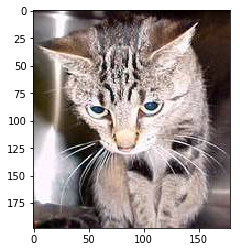

In [5]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [6]:
img.shape

(198, 179, 3)

In [7]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

### Test the proper learning rate:
Determines how quickly to update the weights on each neuron.  Significant impact on the model's performance if it's outside a reasonable band.  Decent technique is to start from a very small value, measure the loss, and increase the learning rate iteratively until we find a point where the loss starts to increase.  The idea is to identify the quickest learning rate that doesn't negatively impact the model's performance.

Mathematically, the learning rate is multiplied by the gradient (derivative) of the loss function at any given point.

In [20]:
%%time
sz = 500
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(resnet34, sz))
learn = ConvLearner.pretrained(resnet34, data, precompute=True)
learn.fit(0.01, 1)

100%|██████████| 32/32 [00:30<00:00,  1.03it/s]


epoch      trn_loss   val_loss   accuracy                     
    0      0.069576   0.040787   0.987305  

CPU times: user 12min 55s, sys: 16min 48s, total: 29min 44s
Wall time: 6min 26s


In [23]:
lrf = learn.lr_find()

 76%|███████▌  | 274/360 [00:03<00:01, 73.71it/s, loss=0.212] 


### Look at what the model's doing:

In [24]:
# Labels for the validation dataset
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [25]:
# cats is 0 and dogs is 1
data.classes

['cats', 'dogs']

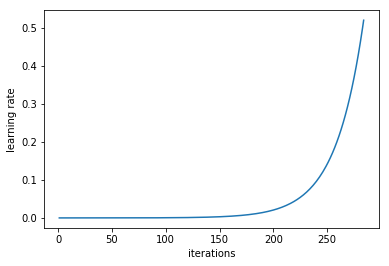

In [12]:
# Tests mini-batches of the data to find a proper learning rate, which we can 
# then plot:
learn.sched.plot_lr()

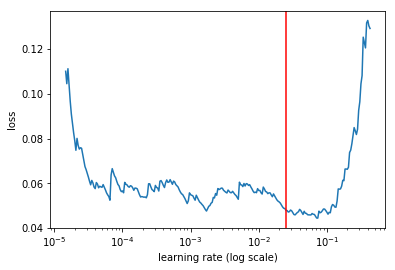

In [19]:
import matplotlib.pyplot as plt
learn.sched.plot()
plt.axvline(x=2.5e-2, color="red");

### Analyze Results:
1. Some correct labels at random
2. Incorrect labels at random
3. Most correct labels for each class (i.e. the easiest to classify)
4. Most incorrect for each class (i.e. where the model is simply off)
5. Closest to 0.5 predictions (i.e. the most uncertain predictions)

In [26]:
log_preds = learn.predict() # make predictions for validation data
log_preds.shape

(2000, 2)

In [27]:
log_preds[:10]

array([[ -0.00001, -11.53608],
       [ -0.00024,  -8.34411],
       [ -0.00149,  -6.51183],
       [ -0.00175,  -6.35136],
       [ -0.00092,  -6.98833],
       [ -0.00254,  -5.97531],
       [ -0.00001, -11.2059 ],
       [ -0.00016,  -8.75099],
       [ -0.00115,  -6.7651 ],
       [ -0.00026,  -8.2523 ]], dtype=float32)

Note that the probabilities shown above are given on the log scale

In [29]:
preds = np.argmax(log_preds, axis=1) # 0/1 predictions
probs = np.exp(log_preds[:, 1]) # probability(dog)

In [30]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [31]:
def plot_vals_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [36]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [34]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correct Predictions


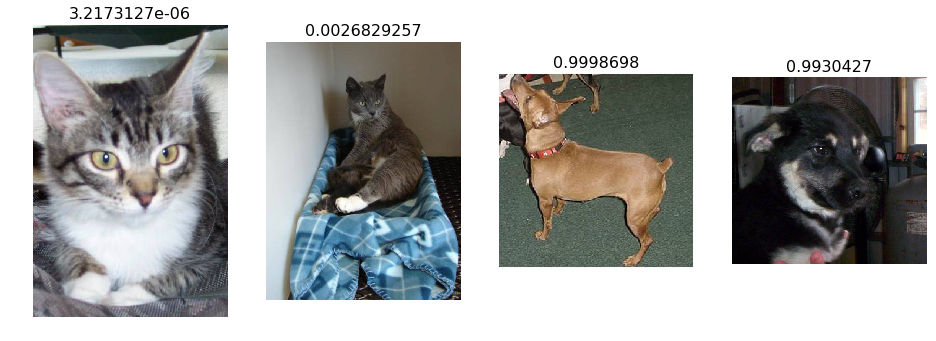

In [38]:
plot_val_with_title(rand_by_correct(True), "Correct Predictions")

Incorrect Predictions


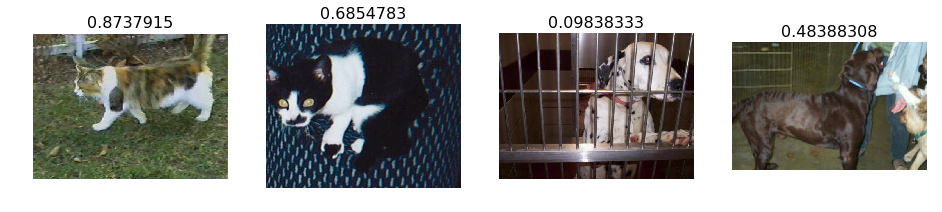

In [40]:
plot_val_with_title(rand_by_correct(False), "Incorrect Predictions")

In [41]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct cats


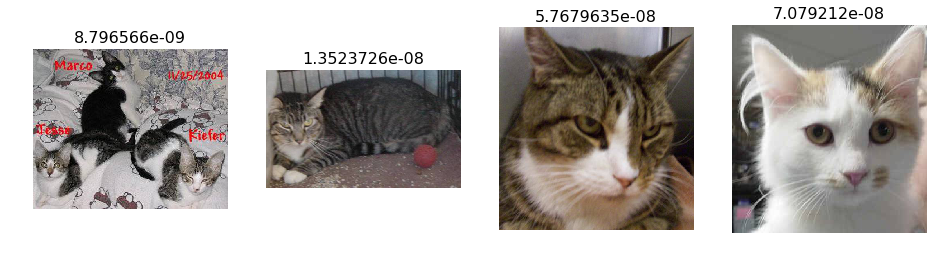

In [42]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


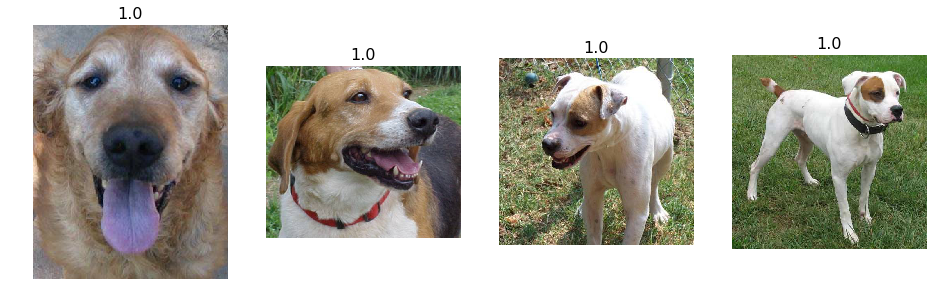

In [43]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


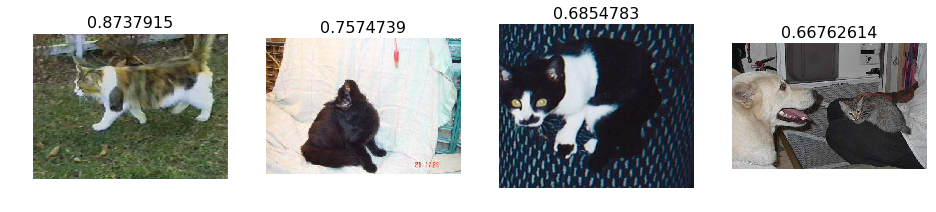

In [44]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


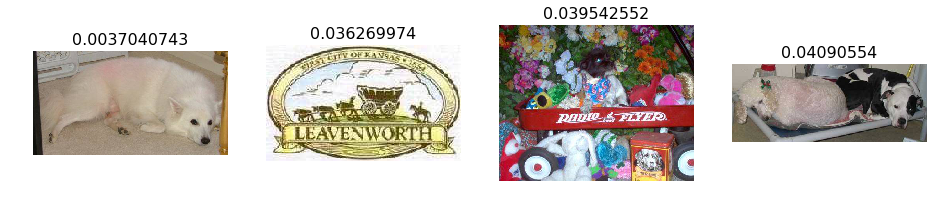

In [45]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


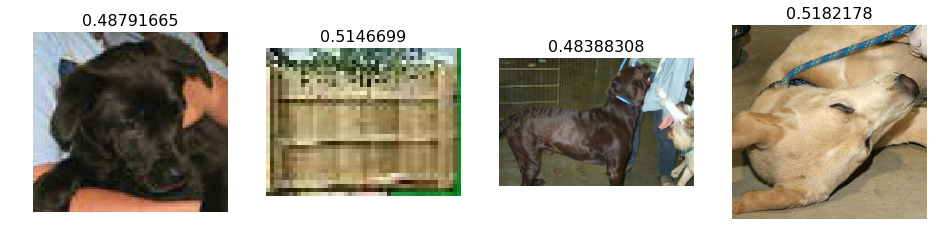

In [46]:
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")